# Word and subword embeddings, a comparison

Task:

Apply techniques for splitting words into smaller units, and train word embeddings (WEs) on both “full” words and combinations of the split products. Comparatively evaluate the two approaches (with splitting vs. without) against a word similarity data set and against a specific short list of potentially rare or OOV items that may (or may not) be synonymous (or closely related).

## Word and subword embeddings

In [1]:
#Libraries
import pandas as pd
import gensim
from scipy.spatial.distance import cosine
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Corpus

The **Leipzig Corpora** Collection presents corpora in different languages using the same format and comparable sources. All data are available as plain text files.
They contain randomly selected sentences in the language of the corpus and are available in sizes from 10,000 sentences up to 1 million sentences. The sources are either newspaper texts or texts randomly collected from the web. The texts are split into sentences.

Donwloading sentences from Leipzig Corpora

In [2]:
# filename = 'eng_wikipedia_2016_100K.tar.gz'
filename = 'eng_wikipedia_2016_300K.tar.gz'
# filename = 'eng_wikipedia_2016_1M.tar.gz'
# filename = 'deu_wikipedia_2021_300K.tar.gz'

link = 'https://downloads.wortschatz-leipzig.de/corpora/' + filename

In [3]:
#Downloading file corpus file
!wget --no-check-certificate --quiet $link -O $filename

#untarring the file
!sudo tar -xzf $filename
!rm $filename #to remove the tar file

In [4]:
#Loading txt file to DataFrame

file_name = filename[:-7]

path = f'/content/{file_name}/{file_name}-sentences.txt'

df_sentences = pd.read_csv(path, sep='\t', index_col=0, header=None, names = ['Sentences'])
df_sentences.tail()

,Sentences
299996,"率土之賓,莫非王臣"" which roughly translates as ""Under ..."
299997,"生 is a particularly complicated example, with ..."
299998,省略号 The dots are always centered within the ba...
299999,"箏, in certain contexts, is also read as sō (箏の..."
300000,"角川日本地名大辞典 46 鹿児島県 p.417 * On November 1, 2004 ..."


### Tokenization

The preprocessing phase serves the purpose of transforming a sequence of raw sentences into a sequence of lists containing useful tokens.

#### Sentence tokenization

**Gensim** is an open-source library for unsupervised topic modeling, document indexing, retrieval by similarity, and other natural language processing functionalities, using modern statistical machine learning.

Gensim provides tools to train and work with word embeddings, such as Word2Vec, Doc2Vec, and other algorithms.

Gensim offers utilities for text preprocessing, such as tokenization, stop-word removal, and stemming.

In [5]:
# Loading libraries for tokenization
from gensim.utils import tokenize
import re

In [6]:
#Preprocess function for tokenization and further text preprocessing
def preprocess(text):

    # Tokenization

    tokens = list(tokenize(text, lowercase=False)) #iteratively yield tokens as unicode strings, removing accent marks


    # Removing tokens (words) without latin pattern
    pattern = re.compile(r'^[a-zA-Z]+$') #Latin pattern
    tokens = [token for token in tokens if pattern.match(token)]

    return tokens

In [7]:
%%time
#Tokenization of Sentences
df_sentences['Word tokens'] = df_sentences['Sentences'].apply(preprocess)
df_sentences['N word tokens'] = df_sentences['Word tokens'].apply(lambda x: len(x))
df_sentences.tail()

CPU times: user 16.2 s, sys: 558 ms, total: 16.7 s
Wall time: 27.6 s


,Sentences,Word tokens,N word tokens
299996,"率土之賓,莫非王臣"" which roughly translates as ""Under ...","[which, roughly, translates, as, Under, the, s...",28
299997,"生 is a particularly complicated example, with ...","[is, a, particularly, complicated, example, wi...",15
299998,省略号 The dots are always centered within the ba...,"[The, dots, are, always, centered, within, the...",24
299999,"箏, in certain contexts, is also read as sō (箏の...","[in, certain, contexts, is, also, read, as, no...",9
300000,"角川日本地名大辞典 46 鹿児島県 p.417 * On November 1, 2004 ...","[p, On, November, the, Towns, of, Yoshida, and...",35


In [ ]:
# Number of tokens in our input data
print('Number of word tokens:',df_sentences['N word tokens'].sum())

Number of word tokens: 6176893


### Word tokenization

Subwords are smaller linguistic units that can be used to break down words into functional components. They are useful particularly when dealing with languages that have complex morphology, compounding, or when handling rare and out-of-vocabulary (OOV) words.

Byte Pair Encoding (BPE) is an unsupervised method that progressively merges the most frequently occurring character pairs to create subword units.

Originally conceived as a data compression algorithm, BPE iteratively merges the most frequent character pairs to segment words into subword units.

BPE algorithm explanation: https://youtu.be/HEikzVL-lZU?si=uUs5hTvGyBHxbiHj

Subword tokenization with Hugging Face Tokenizers

In [8]:
!pip install --quiet tokenizers

In [9]:
%%time
#Building subword tokenizer
from tokenizers import CharBPETokenizer #The original BPE. Represents the BPE algorithm, as introduced by Rico Sennrich

bpe_tokenizer = CharBPETokenizer(
    split_on_whitespace_only=False #spitting on punctuation in addition to whitespaces
    )

bpe_tokenizer.train_from_iterator(
    iterator=df_sentences['Word tokens'].values, #Any iterator over strings or list of strings
    vocab_size=8000, #The desired size of the BPE vocabulary
    min_frequency=2, #Minimum frequency of a subword unit to be included in the vocabulary
    special_tokens=["<unk>"],
    suffix='_'
    )

CPU times: user 52.3 s, sys: 823 ms, total: 53.1 s
Wall time: 49.7 s


In [ ]:
len(bpe_tokenizer.get_vocab(with_added_tokens=True))

8000

In [10]:
%%time
df_sentences['BPE tokens'] = df_sentences['Word tokens'].apply(lambda sentence: bpe_tokenizer.encode(sentence,is_pretokenized=True).tokens)
df_sentences['N subword tokens'] = df_sentences['BPE tokens'].apply(lambda x: len(x))
df_sentences.tail()

CPU times: user 52.3 s, sys: 921 ms, total: 53.2 s
Wall time: 1min 14s


,Sentences,Word tokens,N word tokens,BPE tokens,N subword tokens
299996,"率土之賓,莫非王臣"" which roughly translates as ""Under ...","[which, roughly, translates, as, Under, the, s...",28,"[which_, roughly_, transl, ates_, as_, Under_,...",31
299997,"生 is a particularly complicated example, with ...","[is, a, particularly, complicated, example, wi...",15,"[is_, a_, particularly_, complicated_, example...",21
299998,省略号 The dots are always centered within the ba...,"[The, dots, are, always, centered, within, the...",24,"[The_, do, ts_, are_, always_, cent, ered_, wi...",35
299999,"箏, in certain contexts, is also read as sō (箏の...","[in, certain, contexts, is, also, read, as, no...",9,"[in_, certain_, cont, ex, ts_, is_, also_, rea...",13
300000,"角川日本地名大辞典 46 鹿児島県 p.417 * On November 1, 2004 ...","[p, On, November, the, Towns, of, Yoshida, and...",35,"[p_, On_, November_, the_, T, owns_, of_, Y, o...",66


In [ ]:
# Number of tokens in our input data
print('Number of subword tokens:',df_sentences['N subword tokens'].sum())

Number of subword tokens: 8310816


### Word embedding model (W2V-WE)

**Word embeddings** are dense vector representations of words or subwords in a high-dimensional space. These numerical representations allow machine learning algorithms to work with textual data.

**word2Vec** is a popular algorithm used for learning word embeddings. Word2Vec uses a shallow neural network (two-layer) to learn word embeddings by predicting context words based on target words or vice versa.

word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets.

There are two main architectures:

*   **skip-gram** predicts words within a certain range before and after the current word in the same sentence
*   Continuous Bag of Words (**CBOW**) predicts the middle word based on surrounding context words. This architecture is called a bag-of-words model as the order of words in the context is not important.




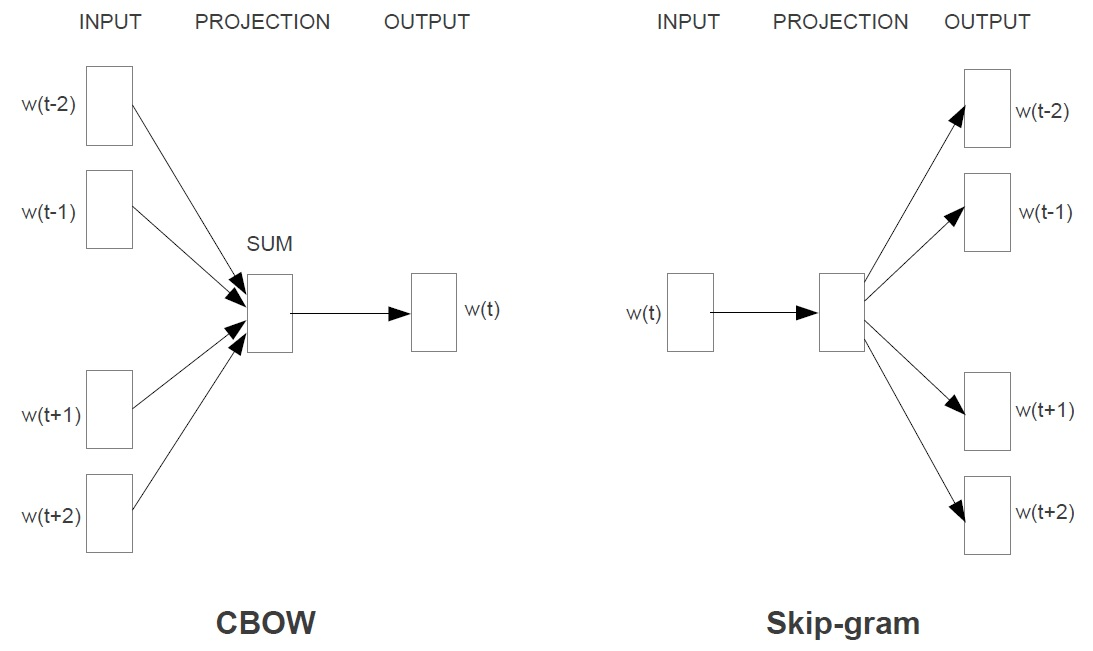

skip-gram predicts words within a certain range before and after the current word in the same sentence

In [11]:
%%time
# Model for word embedding using skim gram
# initialize and train the model
model_we = gensim.models.word2vec.Word2Vec(

    sentences=df_sentences['Word tokens'], #the training is streamed, so 'sentences' can be an iterable
    # corpus_file=path, #path to a corpus file
    vector_size=100, #dimensionality of the word vectors
    window=7, #maximum distance between the current and predicted word within a sentence
    min_count=2, #ignores all words with total frequency lower than this
    workers=2, #use these many worker threads to train the model
    sg=1, #training algorithm: 1 for skip-gram; otherwise CBOW.
    hs=1, #if 1, hierarchical softmax will be used for model training. If 0, negative sampling will be used.
    negative=0, #int for negative specifies how many "noise words" should be draw
    )

model_we.save("model_we.model") #for larger models, Gensim starts storing large raw `numpy` arrays as separate files

CPU times: user 6min 15s, sys: 1.36 s, total: 6min 17s
Wall time: 4min


In [ ]:
#model.wv allows us to access the Word Vectors of the trained model.
word = 'love'
vector = model_we.wv[word]
print('Vector size:',len(vector))
vector[:10]

Vector size: 100


array([ 0.37088746,  0.34987625,  0.2966988 ,  0.06826066,  0.00558338,
       -0.04100309, -0.28178343,  0.03562052,  0.02359551,  0.3445878 ],
      dtype=float32)

In [ ]:
#this method finds the top-N most similar words to a given word based on their vector similarity.
#The range of similarity scores (cosine similarity?) typically falls between -1 and 1.
print(f'More similar words for {word}')
model_we.wv.most_similar(word,
                      topn=3 #number of most similar words to return
                      )

More similar words for love


[('loving', 0.7186440229415894),
 ('loves', 0.7141984701156616),
 ('procreation', 0.7096333503723145)]

In [ ]:
#Size of vocabulary
vocab_size = len(model_we.wv)
print('Vocabulary size:', vocab_size)
#Number of parameters:
print('N of parameters:', vocab_size * 100)

Vocabulary size: 88824
N of parameters: 8882400


In [ ]:
#Model size
model_file_size = os.path.getsize("model_we.model")
# vectors_file_size = os.path.getsize("model_we.model.wv.vectors.npy")

total_size_bytes = model_file_size #+ vectors_file_size

# Convert bytes to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Size of the model file: {total_size_mb:.2f} MB")

Size of the model file: 80.10 MB


In [12]:
# T-distributed Stochastic Neighbor Embedding
# t-SNE is a tool to visualize high-dimensional data

def tsne_plot(model, n_samples=100):
    "Creates and TSNE model and plots it"
    labels = model.wv.index_to_key
    vectors = model.wv.vectors

    tsne_model = TSNE(
        n_components=2, # dimension of the embedded space
        perplexity=40, # number of nearest neighbors that is used in other manifold learning algorithms
        init='pca',
        random_state=23
        )

    # random_indices = np.random.choice(len(labels), size=n_samples, replace=False)
    # vectors = vectors[random_indices]
    # labels = [labels[i] for i in random_indices]
    labels = labels[:n_samples]
    vectors = vectors[:n_samples]

    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10, 10))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

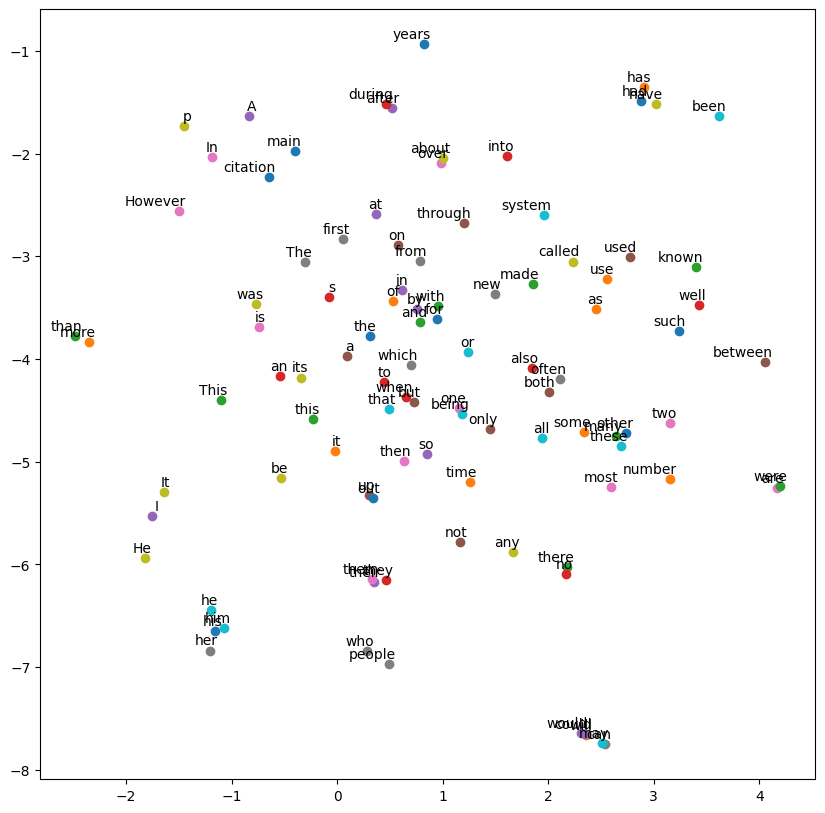

In [ ]:
tsne_plot(model_we)

### Subword embedding model (W2V-SE)

In [13]:
%%time
# Model for subword embedding using skim gram
# initialize and train the model
model_se = gensim.models.word2vec.Word2Vec(

    sentences=df_sentences['BPE tokens'], #the training is streamed, so 'sentences' can be an iterable
    vector_size=100, #dimensionality of the word vectors
    window=7, #maximum distance between the current and predicted word within a sentence
    min_count=2, #ignores all words with total frequency lower than this
    workers=2, #use these many worker threads to train the model
    sg=1, #training algorithm: 1 for skip-gram; otherwise CBOW.
    hs=1, #if 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=0, #int for negative specifies how many "noise words" should be draw
    )

model_se.save("model_se.model")

CPU times: user 8min 45s, sys: 1.46 s, total: 8min 46s
Wall time: 5min 29s


In [ ]:
#Example of subword embedding
word = 'lovely'
tokens = bpe_tokenizer.encode(word).tokens
print(f'Tokens of word {word}',tokens)
vector = sum(model_se.wv[tokens])
print('Vector size:',len(vector))
vector[:10]

Tokens of word lovely ['lo', 'vely_']
Vector size: 100


array([ 0.01179418, -0.26082093, -0.16671717, -0.02830823,  0.08707131,
        0.2629897 ,  0.41693854,  0.13866141,  0.7072581 ,  0.12453355],
      dtype=float32)

In [ ]:
#Size of vocabulary
vocab_size = len(model_se.wv)
print('Vocabulary size:', vocab_size)
#Number of parameters:
print('N of parameters:', vocab_size * 100)

Vocabulary size: 7970
N of parameters: 797000


The vocabulary size is smaller since fewer subwords can form the entire word vocabulary.

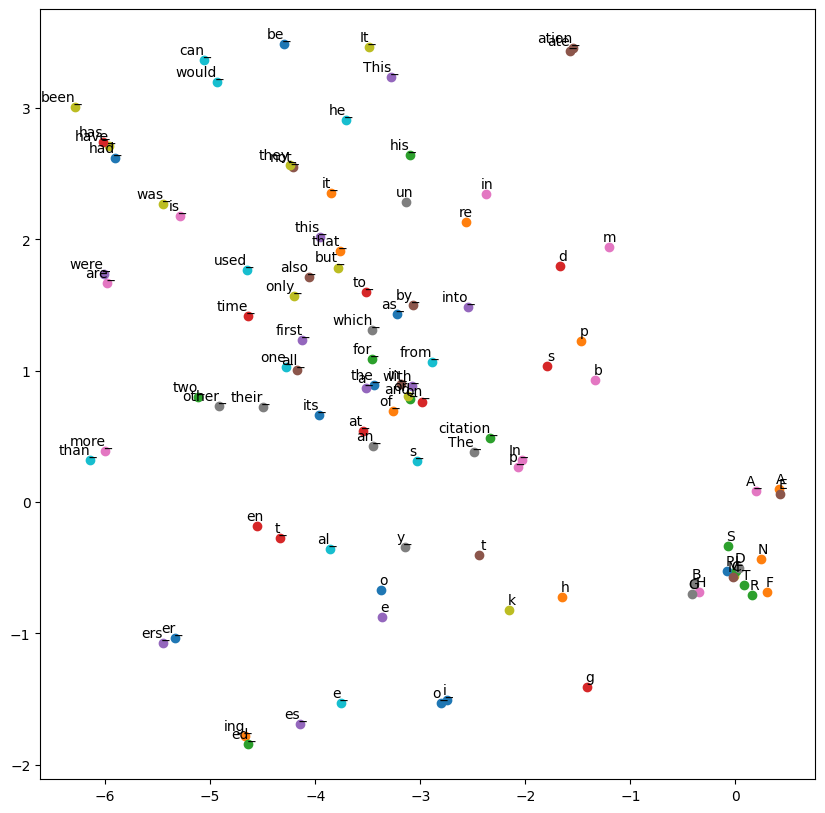

In [ ]:
# T-distributed Stochastic Neighbor Embedding
tsne_plot(model_se)

In [ ]:
#Model size
model_file_size = os.path.getsize("model_se.model")
# vectors_file_size = os.path.getsize("model_se.model.wv.vectors.npy")

total_size_bytes = model_file_size #+ vectors_file_size

# Convert bytes to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Size of the model file: {total_size_mb:.2f} MB")

### Subword-aware Word2Vec model

FastText

FastText is a method that extends the word2vec model by considering subword information. FastText constructs embeddings not only for whole words but also for subword units, such as character n-grams.

FastText provides embeddings for character n-grams, representing words as the average of these embeddings.

It builds two vocabularies: one for whole words and another for subword units (n-grams). Each word’s representation is calculated as the sum of its embedding and the embeddings of its character n-grams.

#### FastText with n-grams (FT-nGram)

In [14]:
%%time
# Model for subword embedding using skim gram
# initialize and train the model
model_se_ft = gensim.models.fasttext.FastText(

    sentences=df_sentences['Word tokens'], #the training is streamed, so 'sentences' can be an iterable
    vector_size=100, #dimensionality of the word vectors
    window=7, #maximum distance between the current and predicted word within a sentence
    min_count=2, #ignores all words with total frequency lower than this
    workers=2, #use these many worker threads to train the model
    sg=1, #training algorithm: 1 for skip-gram; otherwise CBOW.
    hs=1, #if 1, hierarchical softmax will be used for model training. If 0, negative sampling will be used.
    negative=0, #int for negative specifies how many "noise words" should be draw

    min_n=2, #min length of char ngram to be used for training word representations.
    max_n=4, #max length of char ngram to be used for training word representations.
    word_ngrams=1, #max length of word ngram
    bucket=200000 #character ngrams are hashed into a fixed number of buckets, in order to limit the memory usage of the model.
    )

model_se_ft.save("model_se_ft.model")

CPU times: user 12min 7s, sys: 2.66 s, total: 12min 10s
Wall time: 7min 44s


In [21]:
#model.wv contains the mapping between words and embeddings.
print("Present in the vocabulary:", model_se_ft.wv.__contains__('Negress'))
vector = model_se_ft.wv['Negress']
print("Vector size:", len(vector))
vector[:10]

Present in the vocabulary: True
Vector size: 100


array([ 0.24542205, -0.26933342,  0.10378849,  0.13169384, -0.14657903,
       -0.19917372,  0.19689563, -0.19718438, -0.1184693 ,  0.10070001],
      dtype=float32)

In [34]:
# Ngrams
gensim.models.fasttext.compute_ngrams('Negress', 2, 4)

['<N',
 'Ne',
 'eg',
 'gr',
 're',
 'es',
 'ss',
 's>',
 '<Ne',
 'Neg',
 'egr',
 'gre',
 'res',
 'ess',
 'ss>',
 '<Neg',
 'Negr',
 'egre',
 'gres',
 'ress',
 'ess>']

In [15]:
# Full-word-token vectors
model_se_ft.wv.vectors_vocab.shape

(88824, 100)

In [ ]:
# ngram vectors
model_se_ft.wv.vectors_ngrams.shape

(200000, 100)

In [27]:
# subwords map
print("word:", model_se_ft.wv.index_to_key[0])
print("hashes:", model_se_ft.wv.buckets_word[0])

word: the
hashes: [ 54941 151151   9726  59089  61980  60934 163254  16280  58490]


In [ ]:
#Size of vocabulary
vocab_size = len(model_se_ft.wv)
print('Vocabulary size:', vocab_size)
#Number of parameters:
print('N of parameters:', vocab_size * 100)

Vocabulary size: 88824
N of parameters: 8882400


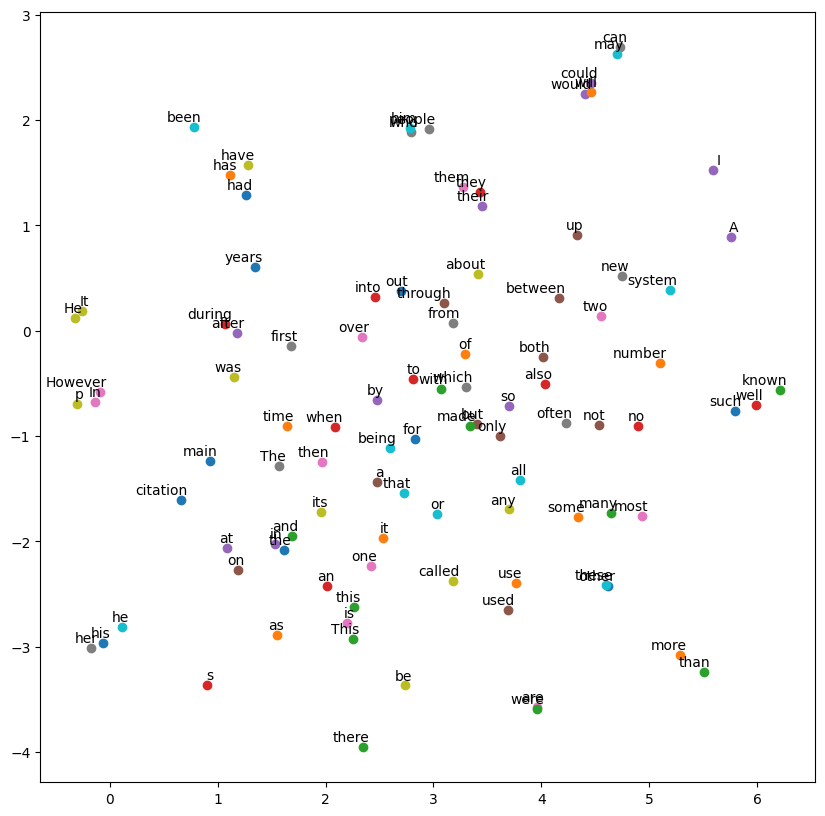

In [ ]:
# T-distributed Stochastic Neighbor Embedding
tsne_plot(model_se_ft)

In [ ]:
#Model size
model_file_size = os.path.getsize("model_se_ft.model")
# vectors_vocab_file_size = os.path.getsize("model_se_ft.model.wv.vectors_vocab.npy")
vectors_ngrams_file_size = os.path.getsize("model_se_ft.model.wv.vectors_ngrams.npy")

total_size_bytes = model_file_size + vectors_ngrams_file_size #+ vectors_vocab_file_size

# Convert bytes to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Size of the model file: {total_size_mb:.2f} MB")

Size of the model file: 161.53 MB


### Evaluation

The word similarity task is a common evaluation benchmark used to assess the quality of word representations (embeddings). In this task we compare similarity measures from word embeddings against human-annotated scores to assess how well the word embeddings align with human intuition regarding word similarities.

In this work we use cosine similarity, a popular directional measure that quantifies the cosine of the angle between two vectors.

Auxiliary functions

In [35]:
#Function to compute the vector representation
def embedding(word, model, tokenizer=None):
    try:
        if tokenizer is None:
            return model.wv[word]
        else:
            return sum(model.wv[tokenizer.encode(word).tokens])
    except:
        return None

#Function to compute the cosine similarity between vector representations
def similarity_cosine(word1,word2,model,tokenizer=None):
    try:
        word1_emb = embedding(word1,model,tokenizer)
        word2_emb = embedding(word2,model,tokenizer)
        return 1 - cosine(word1_emb, word2_emb) #cosine similarity
    except:
        return 'Not found'

#Function to compute the similarity class
def similarity_class(value, threshold=0.5):
    if value != 'Not found':
        if value > threshold:
            return '+'
        else:
            return '-'
    else:
        return 'NA'

def OOVp(df,field):
    df_f = df[df[field] != 'Not found'].reset_index(drop=True)
    n_found = len(df_f)
    n_pairs = len(df)
    return round(1-n_found/n_pairs,3)

def acc(df,field,threshold=0.5):
    df_f = df[df[field] != 'Not found'].reset_index(drop=True)
    df_class = df_f.apply(lambda row: similarity_class(row[field],threshold), axis=1)
    n_hits = sum(df_f['Similarity_class'] == df_class)
    n_pairs = len(df)
    n_pairs_f = len(df_f)

    acc = round(n_hits/n_pairs,2)
    try:
        acc_f = round(n_hits/n_pairs_f,2)
    except:
        acc_f = '-'

    return acc_f, acc

def correlation(df,field,method='pearson'):
    df_f = df[df[field] != 'Not found'].reset_index(drop=True)
    pc = df_f['Similarity'].corr(pd.to_numeric(df_f[field]), method=method)
    return round(pc, 2)

#### WordSim353

WordSim353 is a test collection for measuring word similarity or relatedness, developed and maintained by E. Gabrilovich.

This page contains a split of the test set into two subsets, one for evaluating similarity, and the other for evaluating relatedness.

In [36]:
#Dowloading WordSim353 dataset
!wget -q --no-check-certificate 'http://alfonseca.org/pubs/ws353simrel.tar.gz' -O ws353simrel.tar.gz

#untarring the file
!sudo tar -xzf ws353simrel.tar.gz
!rm ws353simrel.tar.gz #to remove the tar file

In [37]:
#Loading txt file to DataFrame
df_wordsim353_similarity = pd.read_csv('/content/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt', sep='\t', header=None, names = ['Word1','Word2','Similarity'])
df_wordsim353_relatedness = pd.read_csv('/content/wordsim353_sim_rel/wordsim_relatedness_goldstandard.txt', sep='\t', header=None, names = ['Word1','Word2','Similarity'])
df_similarity_1 = pd.concat([df_wordsim353_similarity, df_wordsim353_relatedness], ignore_index=True).drop_duplicates()
df_similarity_1.tail()

,Word1,Word2,Similarity
347,doctor,liability,5.19
348,impartiality,interest,5.16
349,energy,laboratory,5.09
350,secretary,senate,5.06
351,death,inmate,5.03


In [38]:
#List of unique words in the dataset
unique_words = pd.concat([df_similarity_1['Word1'],df_similarity_1['Word2']], ignore_index=True).drop_duplicates().to_frame(name='Word').reset_index(drop=True)
unique_words['dict_we'] = unique_words['Word'].apply(lambda word: 'Not found' if embedding(word,model_we) is None else 'Found')
unique_words['dict_se'] = unique_words['Word'].apply(lambda subword: 'Not found' if embedding(subword,model_se,bpe_tokenizer) is None else 'Found')
unique_words['dict_se_ft'] = unique_words['Word'].apply(lambda word: 'Not found' if embedding(word,model_se_ft) is None else 'Found')

unique_words.tail()

,Word,dict_we,dict_se,dict_se_ft
432,memorabilia,Found,Found,Found
433,row,Found,Found,Found
434,interest,Found,Found,Found
435,senate,Found,Found,Found
436,inmate,Found,Found,Found


In [39]:
#Computing cosine similarity with both models
df_similarity_1['similarity_we'] = df_similarity_1.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_we), axis=1)
df_similarity_1['similarity_se'] = df_similarity_1.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_se, bpe_tokenizer), axis=1)
df_similarity_1['similarity_se_ft'] = df_similarity_1.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_se_ft), axis=1)

df_similarity_1.tail()

,Word1,Word2,Similarity,similarity_we,similarity_se,similarity_se_ft
347,doctor,liability,5.19,0.228919,0.016253,0.366214
348,impartiality,interest,5.16,0.296798,0.107707,0.644136
349,energy,laboratory,5.09,0.284734,0.161973,0.399976
350,secretary,senate,5.06,0.32086,0.106731,0.653629
351,death,inmate,5.03,0.18655,0.178162,0.501830


In [40]:
#OOV proportion
pd.DataFrame({
    'Case':['words','pairs'],
    'OOV_we':[OOVp(unique_words,'dict_we'), OOVp(df_similarity_1,'similarity_we')],
    'OOV_se':[OOVp(unique_words,'dict_se'), OOVp(df_similarity_1,'similarity_se')],
    'OOV_se_ft':[OOVp(unique_words,'dict_se_ft'),OOVp(df_similarity_1,'similarity_se_ft')],
})

,Case,OOV_we,OOV_se,OOV_se_ft
0,words,0.005,0.0,0.0
1,pairs,0.006,0.0,0.0


As shown in the above table the proportion of Out-of-Vocabulary (OOV) words for the WordSim-353 collection is very small. In other words, WordSim-353 collection has only few words not present in the wikipedia corpus used for training the embedding model.

The similarity measures of our datasets and the cosine similarities between the vector representations are not directly comparable.

The similarity scores of WordSim-353 dataset are numbers ranging from 0 to 10. The Pearson correlation coefficient is a popular evaluation metric to measure the performance of word embeddings in similarity tasks.

In [44]:
# Pearson correlation
pd.DataFrame(
    {'pc_we':[correlation(df_similarity_1,'similarity_we','pearson')],
     'pc_se':[correlation(df_similarity_1,'similarity_se','pearson')],
     'pc_se_ft':[correlation(df_similarity_1,'similarity_se_ft','pearson')]
     }
    )

,pc_we,pc_se,pc_se_ft
0,0.61,0.36,0.45


Conclusion:

For test collection WordSim-353, the word embedding (we) has a significant higher correlation with the the human-annotated similarity scores compared with with the subword embeddings.

#### SynEngl

In [45]:
# Downloading SynEngl.txt
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VUvJnzsyj60sWKjFa2iLu4W_hKtgWT2R' -O SynEngl.txt

#Loading txt file to DataFrame
df_similarity_2 = pd.read_csv('SynEngl.txt', sep='\t', header=None, names = ['Word1','Word2','Similarity_class'])
df_similarity_2.tail()

,Word1,Word2,Similarity_class
3995,yieldings,conceding,+
3996,yieldings,stapes,-
3997,zealanders,Zealander,+
3998,zealanders,highlanders,-
3999,zithers,zithern,+


In [ ]:
#Class distribution
df_similarity_2['Similarity_class'].value_counts()

,count
Similarity_class,
-,2000
+,2000


In [46]:
#List of unique words in the dataset
unique_words = pd.concat([df_similarity_2['Word1'],df_similarity_2['Word2']], ignore_index=True).drop_duplicates().to_frame(name='Word').reset_index(drop=True)
unique_words['dict_we'] = unique_words['Word'].apply(lambda word: 'Not found' if embedding(word,model_we) is None else 'Found')
unique_words['dict_se'] = unique_words['Word'].apply(lambda word: 'Not found' if embedding(word,model_se,bpe_tokenizer) is None else 'Found')
unique_words['tokens_se'] = unique_words['Word'].apply(lambda word: bpe_tokenizer.encode(word).tokens)
unique_words['dict_se_ft'] = unique_words['Word'].apply(lambda word: 'Not found' if embedding(word,model_se_ft) is None else 'Found')
unique_words['tokens_se_ft'] = unique_words['Word'].apply(lambda word: gensim.models.fasttext.compute_ngrams(word, 2, 4))

unique_words.tail()

,Word,dict_we,dict_se,tokens_se,dict_se_ft,tokens_se_ft
3275,fetching,Found,Found,"[f, et, ching_]",Found,"[<f, fe, et, tc, ch, hi, in, ng, g>, <fe, fet,..."
3276,courting,Found,Found,"[cour, ting_]",Found,"[<c, co, ou, ur, rt, ti, in, ng, g>, <co, cou,..."
3277,wrongfulness,Not found,Found,"[wr, ong, ful, ness_]",Found,"[<w, wr, ro, on, ng, gf, fu, ul, ln, ne, es, s..."
3278,Zealander,Found,Found,"[Zeal, ander_]",Found,"[<Z, Ze, ea, al, la, an, nd, de, er, r>, <Ze, ..."
3279,zithern,Not found,Found,"[zi, thern_]",Found,"[<z, zi, it, th, he, er, rn, n>, <zi, zit, ith..."


In [47]:
#Computing cosine similarity with both models
df_similarity_2['similarity_we'] = df_similarity_2.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_we), axis=1)
df_similarity_2['similarity_se'] = df_similarity_2.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_se, bpe_tokenizer), axis=1)
df_similarity_2['similarity_se_ft'] = df_similarity_2.apply(lambda row: similarity_cosine(row['Word1'], row['Word2'], model_se_ft), axis=1)

df_similarity_2.tail()

,Word1,Word2,Similarity_class,similarity_we,similarity_se,similarity_se_ft
3995,yieldings,conceding,+,Not found,0.011325,0.414420
3996,yieldings,stapes,-,Not found,0.200858,0.482449
3997,zealanders,Zealander,+,Not found,0.174178,0.758556
3998,zealanders,highlanders,-,Not found,0.373842,0.739163
3999,zithers,zithern,+,Not found,0.741236,0.706064


In [48]:
#OOV proportion
pd.DataFrame({
    'Case':['words','pairs'],
    'OOV_we':[OOVp(unique_words,'dict_we'),OOVp(df_similarity_2,'similarity_we')],
    'OOV_se':[OOVp(unique_words,'dict_se'),OOVp(df_similarity_2,'similarity_se')],
    'OOV_se_ft':[OOVp(unique_words,'dict_se_ft'),OOVp(df_similarity_2,'similarity_se_ft')]
})

,Case,OOV_we,OOV_se,OOV_se_ft
0,words,0.57,0.001,0.0
1,pairs,0.77,0.001,0.0


As shown in the above table the proportion of Out-of-Vocabulary (OOV) words for the SynEngl collection is large. In other words, SynEngl collection has many words that are not present in the wikipedia corpus used for training the embedding model.

Given that SynEngl has a binary categorical similarity measure, we discretize cosine similarity using a threshold values. Values surpassing the threshold denote positive similarities, while those below denote negative ones. This approach allows us to compute the number of hits on the entire dataset, which we can use after to calculate the accuracy as a final evaluation metric of the embeddings.

In [49]:
#Discritization of similarity scores and accuracy

result_list = list()

for _ in range(2,9):
  threshold = _/10

  acc_we = acc(df_similarity_2,'similarity_we', threshold)
  acc_se = acc(df_similarity_2,'similarity_se', threshold)
  acc_se_ft = acc(df_similarity_2,'similarity_se_ft', threshold)

  result_list.append([threshold,f'{acc_we[0]} ({acc_we[1]})', acc_se[0], acc_se_ft[0]])

df_results = pd.DataFrame(result_list,columns=('Threshold', 'Accuracy_we', 'Accuracy_se', 'Accuracy_se_ft'))

df_results

,Threshold,Accuracy_we,Accuracy_se,Accuracy_se_ft
0,0.2,0.64 (0.15),0.58,0.52
1,0.3,0.63 (0.15),0.60,0.55
2,0.4,0.57 (0.13),0.58,0.60
3,0.5,0.51 (0.12),0.57,0.64
4,0.6,0.45 (0.1),0.55,0.64
5,0.7,0.42 (0.1),0.54,0.59
6,0.8,0.41 (0.09),0.53,0.56


Conclusion:

As shown in the table above, the models reach their peak accuracies at different thresholds. W2V-WE shows high accuracies, but these values are computed based only on valid pairs. To observe the effect of OOV words on W2V-WE, we include, between parentheses, the accuracies computed over all the pairs. We can see that when taking into account OOV words, W2V-WE accuracy is considerably lower.

Most of the accuracy values lie between 0.55 and 0.65, which while only slightly better than random guessing (0.5), is conceivable given the complexity of SynEngl vocabulary.

#### Comparison inflected forms, compounds and derived words

We conclude this evaluation with a morphological analysis of the learned embedding. We study the model's performance on different morphological categories using the Sigmorphon dataset

SIGMORPHON 2022 dataset

This dataset, with almost 600,000 words, encompasses eight morphological categories.

Morphological categories:


*   000: Root words (free morphemes)
*   100: Inflection only
*   010: Derivation only
*   001: Compound only
*   101: Inflection and Compound
*   011: Derivation and Compound
*   110: Inflection and Derivation
*   111: Inflection, Derivation, Compound

The conceived goal here is to measure the model capacity to assess the similarity between a root word and its surface form.

In [50]:
# Downloading list of words
!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1EwP2YGe-rEKAxglCcjr_Yi1q4iXzrWeG' -O eng.word.train.tsv
!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1XmduGkg47S_n4r89_kPSXbRdPFj1BRMm' -O eng.word.test.gold.tsv
!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1p0jnSLOa8SjfUPynjcnpK5JvtiCJgiBZ' -O eng.word.dev.tsv

In [51]:
#Concatenating the parts
df_dev = pd.read_csv('eng.word.dev.tsv', sep='\t', header=None, names = ['word','morphemes','class'], dtype={'class':'string'})
df_train = pd.read_csv('eng.word.train.tsv', sep='\t', header=None, names = ['word','morphemes','class'],dtype={'class':'string'})
df_test = pd.read_csv('eng.word.test.gold.tsv', sep='\t', header=None, names = ['word','morphemes','class'],dtype={'class':'string'})

df_sigmorphon = pd.concat([df_train,df_dev,df_test], ignore_index=True)
df_sigmorphon.tail()

,word,morphemes,class
573813,daved,dave @@ed,100
573814,dematerializers,de @@material @@ize @@er @@s,110
573815,tscheffkinites,tscheffkinite @@s,100
573816,squigs,squig @@s,100
573817,registering,register @@ing,100


In [ ]:
#Proportions among categories
df_sigmorphon['class'].value_counts(normalize=True)

010    0.366348
100    0.210497
110    0.193547
000    0.150379
001    0.035203
101     0.02479
011    0.013264
111    0.005972
Name: class, dtype: Float64

In [ ]:
#Classification of words as OVV according to the word embedding model vocabulary
df_sigmorphon['OOV'] = df_sigmorphon.apply(lambda row: not row['word'] in model_we.wv, axis=1)
print('Proportion of OOV in list of words:',round(sum(df_sigmorphon['OOV'])/len(df_sigmorphon),2))

Proportion of OOV in list of words: 0.92


In [ ]:
#Proportion of OVV per class according to the word embedding model vocabulary
df_sigmorphon.groupby(by=['class'])['OOV'].mean().reset_index()

,class,OOV
0,000,0.813965
1,001,0.932624
2,010,0.939491
3,011,0.968335
4,100,0.913509
5,101,0.955149
6,110,0.953440
7,111,0.967610


In [53]:
#Function to extract root words from morphemes
def root(morphemes):
    try:
        morphemes = [substring.replace('@', '') for substring in morphemes.split()]
        return max(morphemes, key=len)
    except:
        return '-'

In [54]:
df_sigmorphon = df_sigmorphon[df_sigmorphon['class'] != '000'].reset_index(drop=True)
df_sigmorphon['root'] = df_sigmorphon['morphemes'].apply(root)
df_sigmorphon.tail()

,word,morphemes,class,root
487523,daved,dave @@ed,100,dave
487524,dematerializers,de @@material @@ize @@er @@s,110,material
487525,tscheffkinites,tscheffkinite @@s,100,tscheffkinite
487526,squigs,squig @@s,100,squig
487527,registering,register @@ing,100,register


In [55]:
%%time
#Computing cosine similarity between surface form and root word with each model

df_sigmorphon['similarity_we'] = df_sigmorphon.apply(lambda row: similarity_cosine(row['word'], row['root'], model_we), axis=1)
df_sigmorphon['similarity_se'] = df_sigmorphon.apply(lambda row: similarity_cosine(row['word'], row['root'], model_se, bpe_tokenizer), axis=1)
df_sigmorphon['similarity_se_ft'] = df_sigmorphon.apply(lambda row: similarity_cosine(row['word'], row['root'], model_se_ft), axis=1)

df_sigmorphon.tail()

CPU times: user 2min 20s, sys: 1.53 s, total: 2min 22s
Wall time: 2min 26s


,word,morphemes,class,root,similarity_we,similarity_se,similarity_se_ft
487523,daved,dave @@ed,100,dave,Not found,0.454124,0.761705
487524,dematerializers,de @@material @@ize @@er @@s,110,material,Not found,0.085491,0.783274
487525,tscheffkinites,tscheffkinite @@s,100,tscheffkinite,Not found,0.956328,0.943799
487526,squigs,squig @@s,100,squig,Not found,0.64732,0.886968
487527,registering,register @@ing,100,register,0.333118,0.315042,0.910366


We compute the average cosine similarity per category of word

In [ ]:
#Function to calculate the average cosine similarity with and without OOV words
def avg_similarity(df,field):
    df_f = df[df[field] != 'Not found'].reset_index(drop=True)
    df_f['_'] = df[field].replace('Not found', 0)
    return round(df_f[field].mean(),2),round(df_f['_'].mean(),2)

In [ ]:
#Discritization of similarity scores and accuracy

result_list = list()

classes = df_sigmorphon['class'].drop_duplicates().to_list()

for clase in classes:

  df_filtered = df_sigmorphon[df_sigmorphon['class'] == clase].reset_index(drop=True)

  avg_we = avg_similarity(df_filtered,'similarity_we')
  avg_se = avg_similarity(df_filtered,'similarity_se')
  avg_se_ft = avg_similarity(df_filtered,'similarity_se_ft')
  avg_se_ft_bpe = avg_similarity(df_filtered,'similarity_se_ft_bpe')

  # result_list.append([clase,f'{avg_we[0]} ({avg_we[1]})',avg_se[0],avg_se_ft[0],avg_se_ft_bpe[0]])
  result_list.append([clase,f'{avg_we[0]} ({avg_we[1]})',f'{avg_se[0]} ({avg_se[1]})',avg_se_ft[0],avg_se_ft_bpe[0]])

df_results = pd.DataFrame(result_list,columns=('Class', 'avg_we', 'avg_se', 'avg_se_ft', 'avg_se_ft_bpe'))

df_results = df_results.sort_values(by=['Class']).reset_index(drop=True)

df_results

,Class,avg_we,avg_se,avg_se_ft,avg_se_ft_bpe
0,001,0.22 (0.01),0.5 (0.38),0.74,0.47
1,010,0.3 (0.02),0.55 (0.55),0.74,0.50
2,011,0.2 (0.0),0.42 (0.27),0.70,0.40
3,100,0.43 (0.03),0.78 (0.77),0.88,0.72
4,101,0.2 (0.01),0.4 (0.38),0.69,0.37
5,110,0.24 (0.01),0.48 (0.48),0.70,0.43
6,111,0.16 (0.01),0.38 (0.35),0.66,0.37


Category wise, as expected, the higher the number of morphological derivations, the lower the average cosine similarity. Interestingly, a performance peak emerges in inflexional forms, potentially attributed to the morphological distribution of words in the English language.